In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

from pycaret.classification import ClassificationExperiment
from pycaret.classification import *

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap

DATA_PATH = "./data/pet_store_records_2020.csv"

# Read data

In [2]:
datasheet = pd.read_csv(DATA_PATH, sep=",", index_col=0)
datasheet.head()

,product_category,sales,price,VAP,vendor_id,country,pet_size,pet_type,rating,re_buy
product_id,,,,,,,,,,
5040,Equipment,123,7293,0,VC_1605,Vietnam,small,fish,7,1
4567,Toys,61,9304,1,VC_1132,India,small,cat,10,0
4237,Toys,218,8180,0,VC_802,India,small,hamster,6,0
4364,Snack,69,18559,1,VC_929,India,large,dog,1,1
4184,Supplements,138,10283,1,VC_749,India,large,dog,10,0


In [3]:
datasheet = datasheet.drop([
    'vendor_id', 
    'VAP', 
    'country', 
    'pet_size'
], axis=1)
datasheet.head()

,product_category,sales,price,pet_type,rating,re_buy
product_id,,,,,,
5040,Equipment,123,7293,fish,7,1
4567,Toys,61,9304,cat,10,0
4237,Toys,218,8180,hamster,6,0
4364,Snack,69,18559,dog,1,1
4184,Supplements,138,10283,dog,10,0


### Plotting for analysis

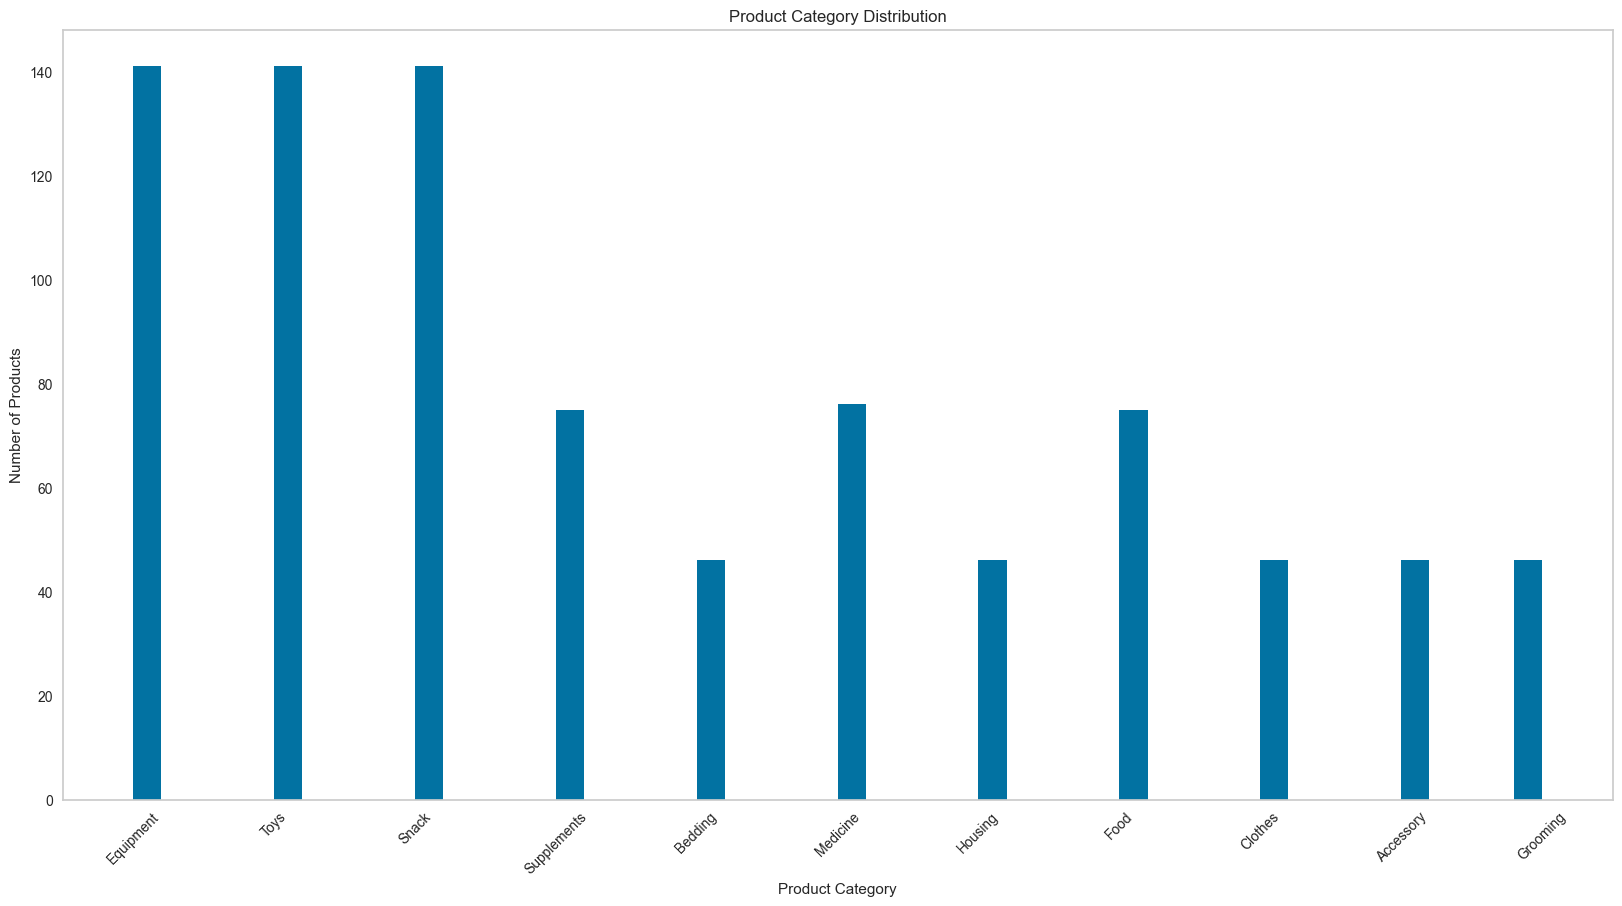

In [4]:
plt.figure(figsize=(20, 10))
plt.hist(datasheet['product_category'], bins=50)
plt.grid()
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)
plt.show()

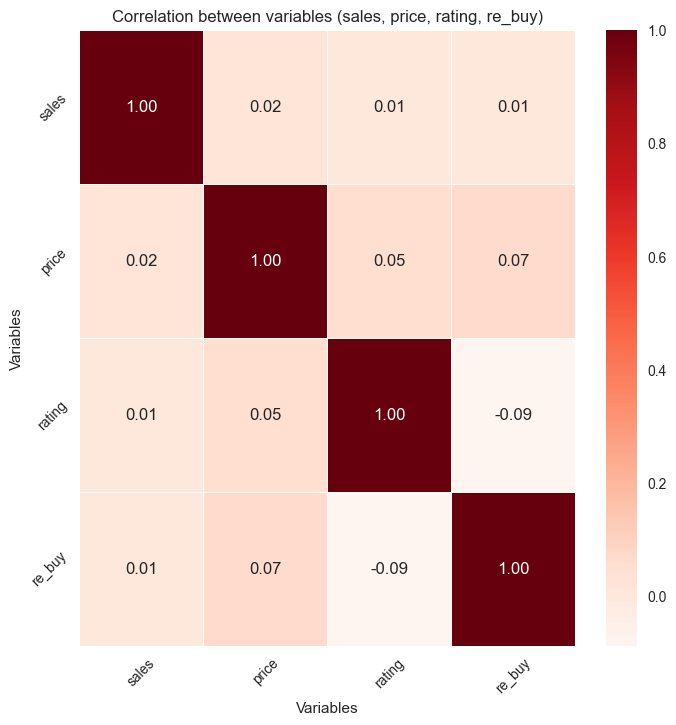

In [5]:
relationship = datasheet[["sales", "price", "rating", "re_buy"]].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(relationship, annot=True, fmt=".2f", linewidths=.5, cmap='Reds')
plt.title("Correlation between variables (sales, price, rating, re_buy)")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.xticks([0.5, 1.5, 2.5, 3.5], ["sales", "price", "rating", "re_buy"], rotation=45)
plt.yticks([0.5, 1.5, 2.5, 3.5], ["sales", "price", "rating", "re_buy"], rotation=45)
plt.show()

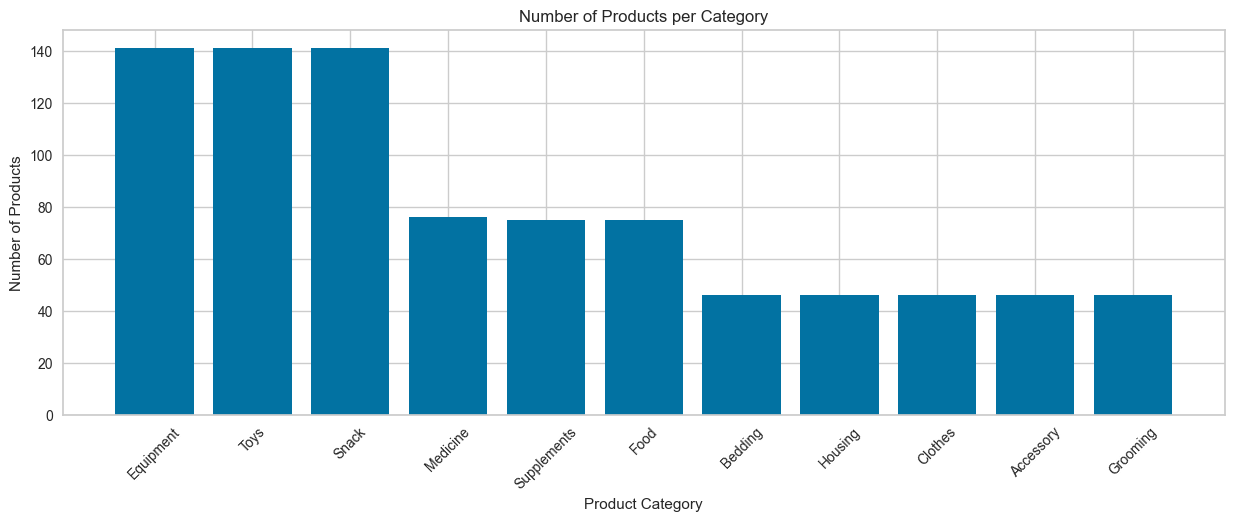

In [6]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['product_category'].value_counts())), height=datasheet['product_category'].value_counts())
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Number of Products per Category')
plt.xticks(range(len(datasheet['product_category'].value_counts())), datasheet['product_category'].value_counts().index, rotation=45)
plt.grid(True)
plt.show()

# Pre-processing

In [7]:
org_product_category = datasheet['product_category'].to_list()
product_category_uni = datasheet['product_category'].unique()
product_category_uni_code = [i for i in range(len(product_category_uni))]
for i in range(len(product_category_uni)):  print(f"[{product_category_uni[i]}]\t->\t[{product_category_uni_code[i]}]")

product_category = []
for i in range(len(org_product_category)):
    for j in range(len(product_category_uni)):
        if org_product_category[i] == product_category_uni[j]:
            product_category.append(product_category_uni_code[j])

datasheet['product_category'] = product_category

[Equipment]	->	[0]
[Toys]	->	[1]
[Snack]	->	[2]
[Supplements]	->	[3]
[Bedding]	->	[4]
[Medicine]	->	[5]
[Housing]	->	[6]
[Food]	->	[7]
[Clothes]	->	[8]
[Accessory]	->	[9]
[Grooming]	->	[10]


In [8]:
org_pet_type = datasheet['pet_type'].to_list()
pet_type_uni = datasheet['pet_type'].unique()
pet_type_uni_code = [i for i in range(len(pet_type_uni))]
for i in range(len(pet_type_uni)):  print(f"[{pet_type_uni_code[i]}]\t->\t{pet_type_uni[i]}")

pet_type = []
for i in range(len(org_pet_type)):
    for j in range(len(pet_type_uni)):
        if org_pet_type[i] == pet_type_uni[j]:
            pet_type.append(pet_type_uni_code[j])

datasheet['pet_type'] = pet_type

[0]	->	fish
[1]	->	cat
[2]	->	hamster
[3]	->	dog
[4]	->	bird
[5]	->	rabbit


In [9]:
datasheet.head()

,product_category,sales,price,pet_type,rating,re_buy
product_id,,,,,,
5040,0,123,7293,0,7,1
4567,1,61,9304,1,10,0
4237,1,218,8180,2,6,0
4364,2,69,18559,3,1,1
4184,3,138,10283,3,10,0


# Train, Test(Validation) Split

In [10]:
target = "product_category"

In [11]:
y_data = datasheet[target].to_numpy()
X_data = datasheet.drop([target], axis=1).to_numpy()

print(f"""X_data shape: {X_data.shape}
y_data shape: {y_data.shape}""")

X_data shape: (879, 5)
y_data shape: (879,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, shuffle=True, stratify=y_data)
print(f"""X_train: {X_train.shape}
y_train: {y_train.shape}
X_test: {X_test.shape}
y_test: {y_test.shape}""")

X_train: (703, 5)
y_train: (703,)
X_test: (176, 5)
y_test: (176,)


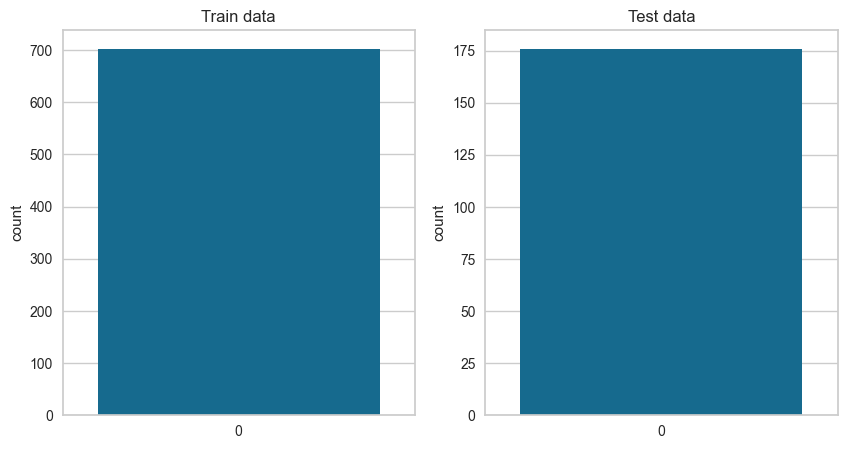

In [13]:
# X_train, y_train, X_test, y_test distribution plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Train data')

plt.subplot(1, 2, 2)
sns.countplot(y_test)
plt.title('Test data')

plt.show()

In [14]:
s = setup(datasheet, target=target, session_id=123)

,Description,Value
0,Session id,123
1,Target,product_category
2,Target type,Multiclass
3,Original data shape,"(879, 6)"
4,Transformed data shape,"(879, 6)"
5,Transformed train set shape,"(615, 6)"
6,Transformed test set shape,"(264, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [15]:
exp = ClassificationExperiment()
exp.setup(data=datasheet, target=target)

,Description,Value
0,Session id,2769
1,Target,product_category
2,Target type,Multiclass
3,Original data shape,"(879, 6)"
4,Transformed data shape,"(879, 6)"
5,Transformed train set shape,"(615, 6)"
6,Transformed test set shape,"(264, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [16]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.1804,0.5614,0.1804,0.1324,0.1443,0.0464,0.0484,0.0220
lr,Logistic Regression,0.1790,0.5041,0.1790,0.1053,0.1296,0.0364,0.0383,0.5330
rf,Random Forest Classifier,0.1724,0.5990,0.1724,0.1490,0.1563,0.0555,0.0561,0.1790
qda,Quadratic Discriminant Analysis,0.1691,0.5594,0.1691,0.1337,0.1375,0.0348,0.0361,0.0180
ridge,Ridge Classifier,0.1676,0.0000,0.1676,0.1245,0.1300,0.0202,0.0211,0.0140
dt,Decision Tree Classifier,0.1674,0.5310,0.1674,0.1711,0.1633,0.0614,0.0618,0.0160
lda,Linear Discriminant Analysis,0.1660,0.5292,0.1660,0.1143,0.1308,0.0246,0.0254,0.0120
knn,K Neighbors Classifier,0.1626,0.5016,0.1626,0.1098,0.1239,0.0216,0.0228,0.0140
dummy,Dummy Classifier,0.1578,0.5000,0.1578,0.0250,0.0431,0.0000,0.0000,0.0240
et,Extra Trees Classifier,0.1577,0.5916,0.1577,0.1548,0.1508,0.0432,0.0436,0.1250


In [17]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

mse_loss = mean_squared_error(y_test, y_pred)
print("MSE Loss: ", mse_loss)

r2_score = r2_score(y_test, y_pred)
print("R2 Score: ", r2_score)

MSE Loss:  13.920454545454545
R2 Score:  -0.4364905921859177


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.10      0.11        29
           1       0.15      0.29      0.19        28
           2       0.15      0.28      0.20        29
           3       0.07      0.20      0.10        15
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         9

    accuracy                           0.12       176
   macro avg       0.04      0.08      0.06       176
weighted avg       0.08      0.12      0.09       176



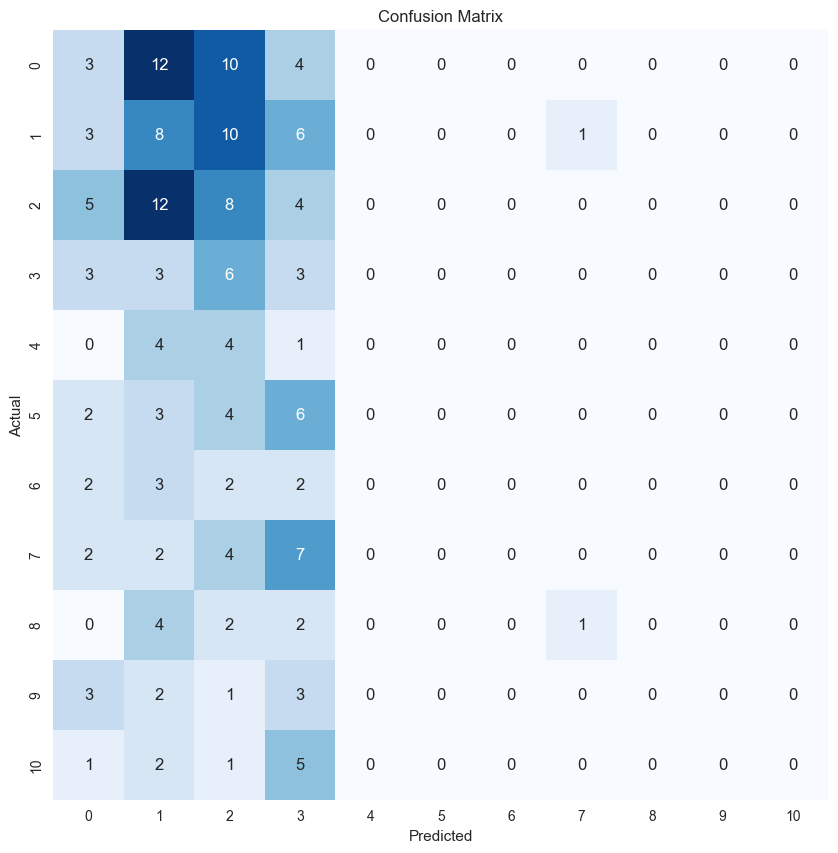

In [19]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(y_test)
ticks_labels.sort()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels)

plt.show()

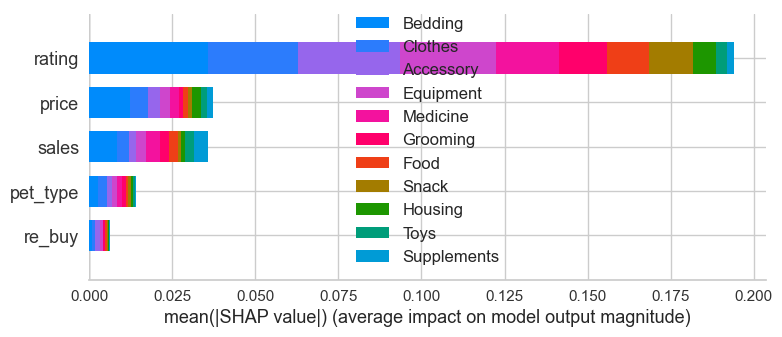

In [35]:
explainer = shap.TreeExplainer(classifier)
excepted_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)

feature_names = list(datasheet.columns)[1:]
class_names = np.unique(org_product_category).tolist()
shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=class_names, plot_type="bar")